## Computing the audiogram
The animal audiograms database contains [44 audiograms](https://animalaudiograms.museumfuernaturkunde.berlin/advanced?order_by=vernacular_name_english&species=698422&taxon=698422&method=&publication=&facility=&from=&to=&medium=water&sex=&liberty=&lifestage=&duration_in_captivity_from=&duration_in_captivity_to=&sedated=&age_from=&age_to=&position=&distance_from=&distance_to=&threshold_from=&threshold_to=&tone=&staircase=&form=&constants=) of harbour seals (*Phoca vitulina* and *P. vitulina vitulina*) in water.

All the audiograms for harbour seals were downloaded and stored in the file `data/Phoca_vitulina_all.csv` (downloading data for complex queries is an experimental feature that is not yet released on the public database). The data can now be loaded and a compound audiogram can be calculated:

In [4]:
# Read the downloaded data
data_file <- "./data/Phoca_vitulina_all.csv"
audiogram <- read.table(data_file, header=TRUE, sep=",")

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


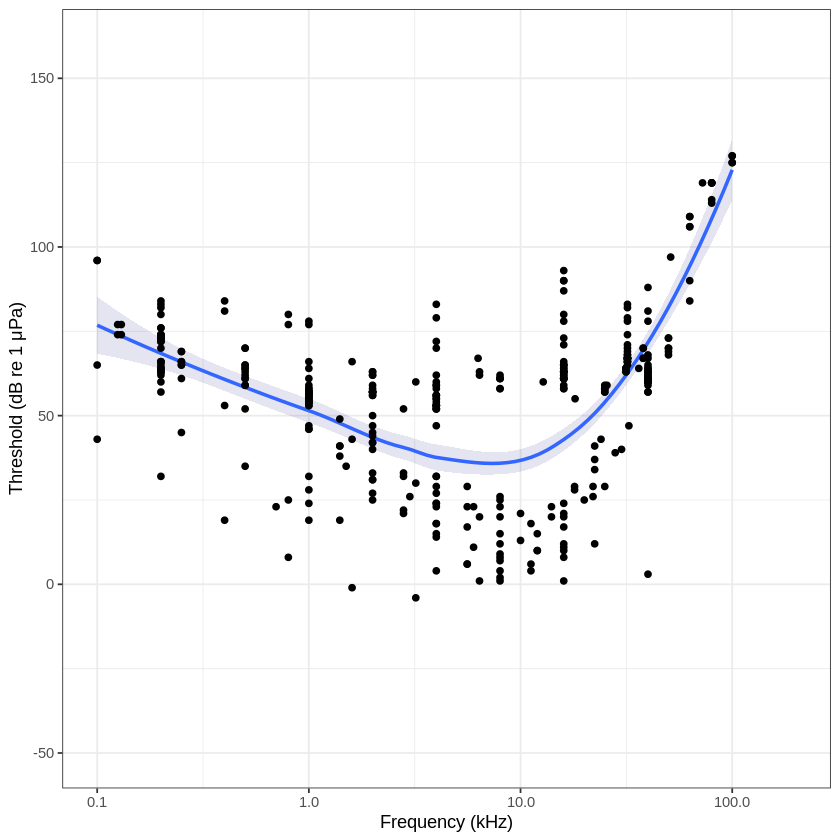

In [6]:
library(ggplot2)

# prepare the labels for the plot axes
label_x <- "Frequency (kHz)"
label_y <- paste0("Threshold (dB ", audiogram$SPL.reference[1], ")")

# add some sensible limits
limits_x <- c(0.1, 200)  # Plot frequencies from 0.1 to 200 kHz
limits_y <- c(-50, 160)  # Plot SPL from -50 to 160 dB

ggplot(audiogram, aes(Frequency.in.kHz, SPL)) +
    labs(x = label_x, y = label_y) +
    geom_smooth(method='loess', formula = y ~ x, fill='navy', alpha=0.1) +
    geom_point() +
    scale_x_log10(limits = limits_x) +
    scale_y_continuous(limits = limits_y) +
    theme_bw()

## Defining the filter values
The filter is constructed based on the audiogram:
* 10 equalization steps are computed (10 is an arbitrary number, but should suffice)
* steps are spaced at equal distance of the logarithmic frequency scale
* for each step, the dB that need to be substracted relatively to the best hearing performance need to be computed
* As the recordings' sample rate tops at 48 kHz, the highest filter band is 24 kHz

In [119]:
# define the fit function (same as in the plot)
audiogram.lo <- loess(
    SPL ~ Frequency.in.kHz, 
    audiogram, 
    control = loess.control(surface = "direct"))

# Frequency.in.kHz, 10 equally spaced log steps, fom 10Hz to 24 kHz (half sampling rate)
seq.log <- exp( seq(log(0.001), log(24), length.out=10 ))

seq <- seq(0.01, 24, length.out=10)

# Fitted SPL values, with extrapolation to avoid NAs
SPL.fit <- predict(audiogram.lo, data.frame(Frequency.in.kHz = seq.log), se = TRUE)$fit

# calculate SPL relative to best hearing performance
SPL.rel <- min(SPL.fit) - SPL.fit

# Print result as a table
filter.table <- data.frame(round(seq.log*1000), round(SPL.rel))
colnames(filter.table) <- c("Frequency.in.Hz", "Gain.in.dB")
filter.table

Frequency.in.Hz,Gain.in.dB
<dbl>,<dbl>
1,-38
3,-38
9,-38
29,-38
88,-38
271,-36
832,-31
2552,-19
7826,0


## Testing the filter
The filter was tested by applying it to a file containing 1 second of white noise. The result can be checked visually in the following FFT plots.

Generate white noise and save it to file
`sox -n data/whitenoise.wav synth 1 whitenoise`

Apply EQ with filters values from table above. Q is set to 1.4 (1 octave) for all frequencies
`sox data/whitenoise.wav data/filtertest.wav equalizer 1 1.4 -38 equalizer 3 1.4 -38 equalizer 9 1.4 -38 equalizer 29 1.4 -38 equalizer 88 1.4 -38 equalizer 271 1.4 -36 equalizer 832 1.4 -31 equalizer 2552 1.4 -19 equalizer 7826 1.4 0 equalizer 24000 1.4 -28`

`sox data/whitenoise.wav data/filtertest.wav equalizer 10 1.4 -37 equalizer 24 1.4 -37 equalizer 56 1.4 -37 equalizer 134 1.4 -36 equalizer 318 1.4 -35 equalizer 755 1.4 -31 equalizer 1793 1.4 -23 equalizer 4257 1.4 -9 equalizer 10107 1.4 0 equalizer 24000 1.4 -28`

`sox data/whitenoise.wav data/filtertest.wav equalizer 1 0.7 -38 equalizer 3 0.7 -38 equalizer 9 .7 -38 equalizer 29 0.7 -38 equalizer 88 0.7 -38 equalizer 271 0.7 -36 equalizer 832 0.7 -31 equalizer 2552 0.7 -19 equalizer 7826 0.7 0 equalizer 24000 0.7 -28


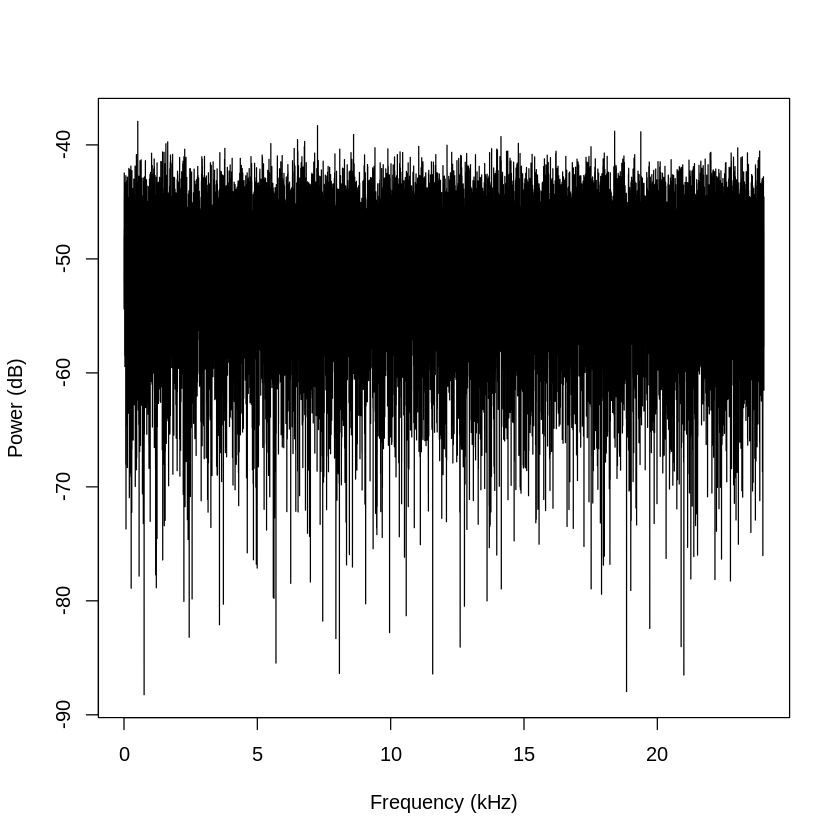

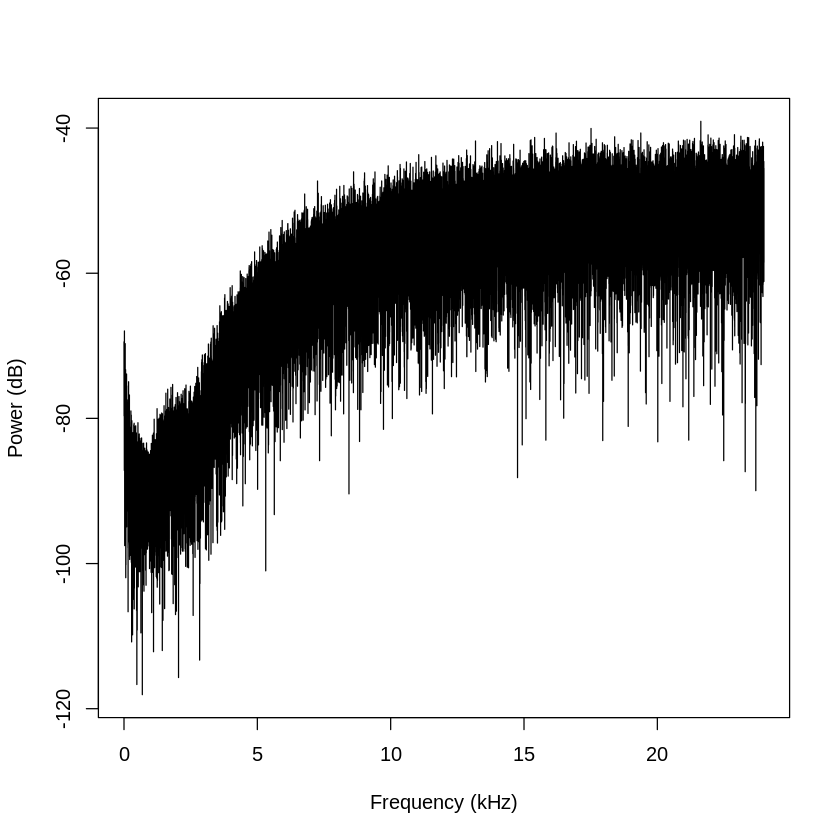

In [120]:
library(tuneR)

# Plot FFT. see Carcagno, 2013
plot_fft <- function(sndObj) {
  # convert data to range -1, 1
  # s1 <- sndObj@.Data
  s1 <- sndObj@.Data[!is.na(sndObj@.Data)]
    
  #s1 <- sndObj@.Data
    
  s1 <- s1 / 2^(wnObj@bit -1)
  # compute fft
  n <- length(s1)
  p <- fft(s1)

  # plot fft
  nUniquePts <- ceiling((n+1)/2)
  p <- p[1:nUniquePts] #select just the first half since the second half 
                     # is a mirror image of the first
  p <- abs(p)  #take the absolute value, or the magnitude, drop phase info
  p <- p / n #scale by the number of points so that
           # the magnitude does not depend on the length 
           # of the signal or on its sampling frequency  
  p <- p^2  # square it to get the power 

  # multiply by two (see technical document for details)
  # odd nfft excludes Nyquist point
  if (n %% 2 > 0){
    p[2:length(p)] <- p[2:length(p)]*2 # we've got odd number of points fft
  } else {
    p[2: (length(p) -1)] <- p[2: (length(p) -1)]*2 # we've got even number of points fft
  }

  freqArray <- (0:(nUniquePts-1)) * (sndObj@samp.rate / n) #  create the frequency array 

  plot(freqArray/1000, 10*log10(p), type='l', col='black', xlab='Frequency (kHz)', ylab='Power (dB)')
}

# load white noise file and plot it
wnObj <- readWave('data/whitenoise.wav')
plot_fft(wnObj)

# load filtered white noise file and plot it
fwnObj <- readWave('data/filtertest.wav')#
plot_fft(fwnObj)



# References
Carcagno, S. (2013) Basic Sound Processing with R. http://samcarcagno.altervista.org/blog/basic-sound-processing-r/?doing_wp_cron=1601298903.9209051132202148437500